# Code for using FiftyOne to train a Faster RCNN on COCO data

###  Imports

In [1]:
import torch
from model import create_model
from utils import FeatureExtractor

import config

torch.manual_seed(1)

In [2]:
import clip
CLIP_model, preprocess = clip.load("RN50")
image_embedder = list(CLIP_model.visual.children())[-1].cuda().eval()#take the last layer manually load in the latest checkpoint

MODEL_TYPE = 'CLIP-FRCNN'
CHECKPOINT_NAME = f'{MODEL_TYPE}_epoch_22.pth'
num_classes = 6  #number of classes in the FRCNN not counting the background


### Training and Evaluation

In [3]:
model = create_model(MODEL_TYPE, num_classes=(num_classes+1))
checkpoint = torch.load(CHECKPOINT_NAME)
model = create_model(MODEL_TYPE, num_classes=(num_classes+1))

model.load_state_dict(checkpoint)

<All keys matched successfully>

In [23]:
#TEST out replacing the box head and box predictors
from model import CLIPHead, CLIPRCNNPredictor
test_text = text_tokens = clip.tokenize(['this is background', "This is test_text"]).cuda()
model.roi_heads.box_head = CLIPHead()
model.roi_heads.box_predictor = CLIPRCNNPredictor(1024, test_text)  #CLIP embeds into 1024 dimensions for the RN50 implementation

In [39]:
from torch.cuda.amp import autocast
model.eval().to(config.DEVICE)
test_image = [torch.rand(3, 224, 224).cuda()]
with autocast():
    out = model(test_image)
print(out[0]['labels'].shape)

# Set up for CLIP integration

In [9]:
model.eval().to(config.DEVICE)

#the below is exactly what YOLO does, however in FRCNN we take this data, do roi pooling and continue from there
# create a hook for the region of interest embedding
FRCNN_roi = FeatureExtractor(model, layers=['roi_heads.box_roi_pool']) #grab the feature extractor, this contains the rois projected into the clip image embedding space
FRCNN_RPN_bbox = FeatureExtractor(model, layers=['rpn.head.bbox_pred']) #grab the RPN bbox regressors, this contains a regressor for each anchor box in each segment of the FRCNN embedded image
FRCNN_RPN_cls = FeatureExtractor(model, layers=['rpn.head.cls_logits']) #grab the RPN logits, this contains a probability for each anchor box in each segment of the FRCNN embedded image

tnsr = torch.rand(1, 3, 224, 224).to(config.DEVICE)

test_rois = FRCNN_roi(tnsr)
test_bbox = FRCNN_RPN_bbox(tnsr)
test_logits = FRCNN_RPN_cls(tnsr)
test_out = model(tnsr)

print(f'ROI shape: {test_rois.shape}')
print(f'RPN_bbox shape: {test_bbox.shape}')
print(f'RPN_logit shape: {test_logits.shape}')
print(f'FRCNN output: {test_out}')

ROI shape: torch.Size([79, 2048, 7, 7])
RPN_bbox shape: torch.Size([1, 60, 25, 25])
RPN_logit shape: torch.Size([1, 15, 25, 25])
FRCNN output: [{'boxes': tensor([], device='cuda:0', size=(0, 4), dtype=torch.float16,
       grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', dtype=torch.float16, grad_fn=<IndexBackward0>)}]


In [28]:
model.roi_heads.score_thresh

0.05

In [18]:
model.roi_heads.detections_per_img

100

# Bring in some test images and labels

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "background": "there is nothing here",
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}


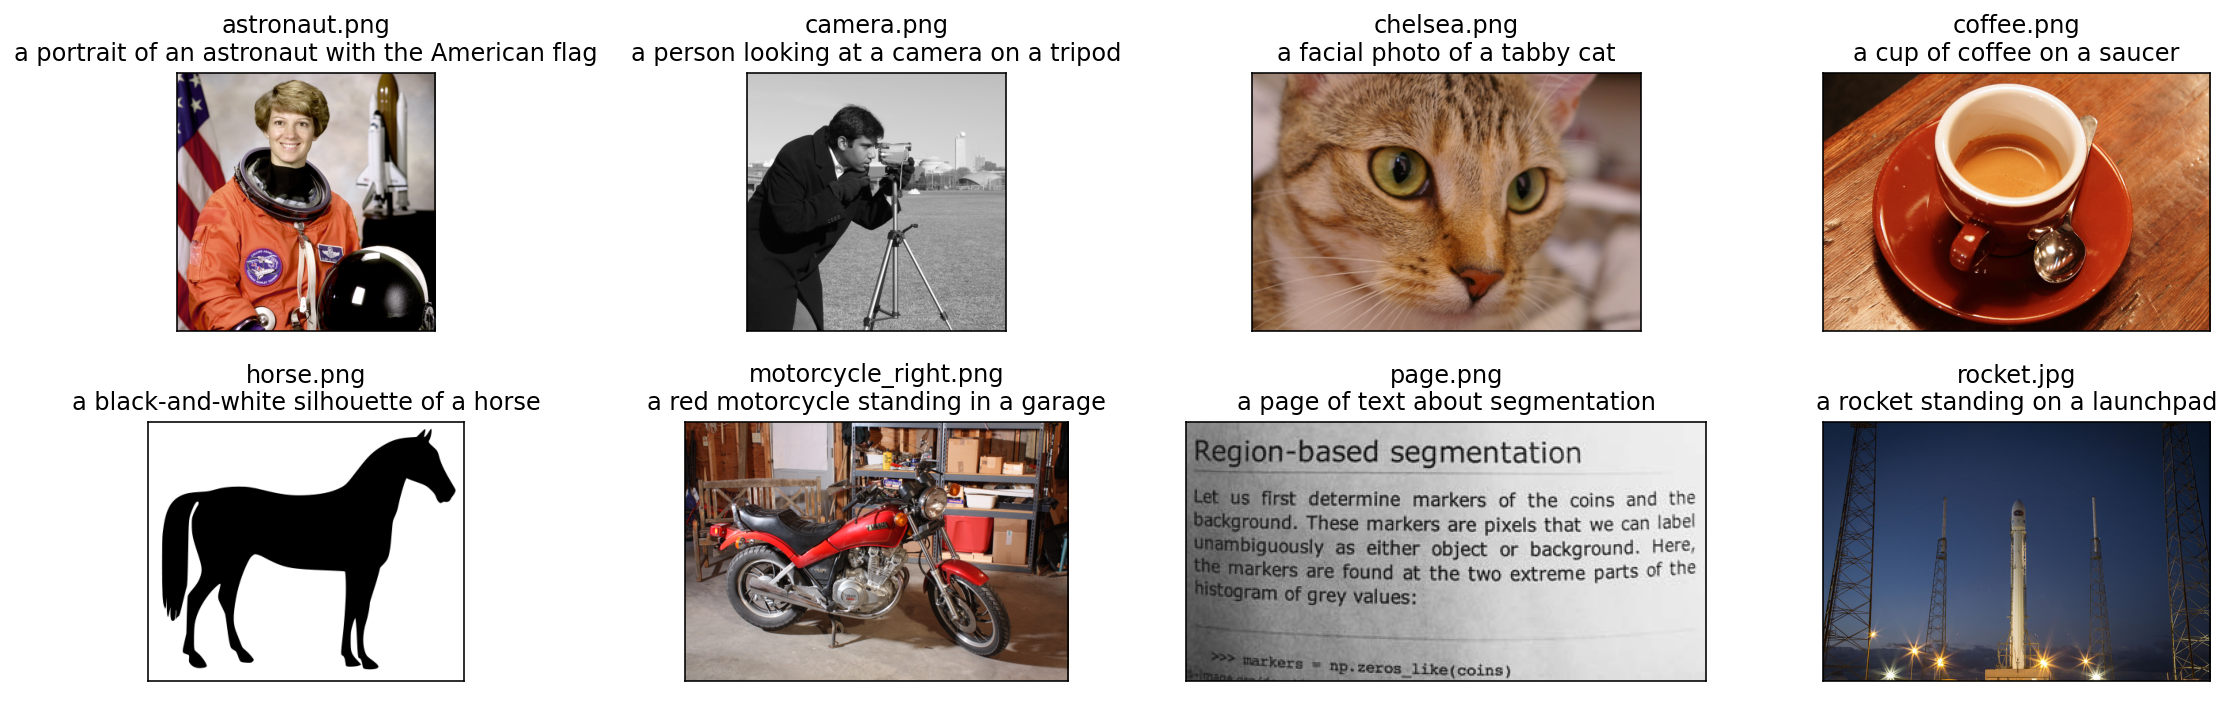

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

#texts.append(descriptions["background"])

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(image)
    texts.append(descriptions[name])

plt.tight_layout()

In [10]:
image = np.array(image)
from dataset import get_transforms
_, test_transforms = get_transforms()
transformed_image, _ = test_transforms(image, [0,0,0,0,])
transformed_image = transformed_image.unsqueeze(0).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [13]:
text_tokens.shape

torch.Size([8, 77])

In [11]:
# encode and normalize the text using CLIP
with torch.no_grad():
    text_features = CLIP_model.encode_text(text_tokens).float()  #  encode the text tokens into CLIP space
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize the text features

In [10]:
image_FRCNN = model(transformed_image)
image_rois = FRCNN_roi(transformed_image).to(config.DEVICE)
rpn_logits = FRCNN_RPN_cls(transformed_image).to(config.DEVICE)
rpn_bbox = FRCNN_RPN_bbox(transformed_image).to(config.DEVICE)

print(f'ROI shape: {image_rois.shape}')
print(f'RPN_bbox shape: {rpn_bbox.shape}')
print(f'RPN_logit shape: {rpn_logits.shape}')
print(f'FRCNN output: {image_FRCNN}')

ROI shape: torch.Size([292, 2048, 7, 7])
RPN_bbox shape: torch.Size([1, 60, 25, 38])
RPN_logit shape: torch.Size([1, 15, 25, 38])
FRCNN output: [{'boxes': tensor([[623.0000, 405.5000, 636.5000, 418.2500],
        [298.7500, 146.7500, 319.2500, 175.3750],
        [300.2500, 147.2500, 325.7500, 190.0000]], device='cuda:0',
       dtype=torch.float16, grad_fn=<StackBackward0>), 'labels': tensor([6, 6, 6], device='cuda:0'), 'scores': tensor([0.0743, 0.0544, 0.0503], device='cuda:0', dtype=torch.float16,
       grad_fn=<IndexBackward0>)}]


In [85]:
#compare each roi with the clip text embeddings
roi_similarity = []
roi_probability = []

for roi in image_rois:
    roi_embedding = image_embedder(roi.unsqueeze(0)).float()
    roi_embedding /= roi_embedding.norm(dim=-1, keepdim=True)

    roi_similarity.append(text_features.cpu().numpy() @ roi_embedding.detach().cpu().numpy().T)
    roi_probability.append(torch.softmax((100.0 * roi_embedding @ text_features.T), dim=-1))

In [ ]:
batch_size, filters, x, y = full_image_features.shape  #from the feature map, grab some information to be used in performing the inference

# encode and normalize the text
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()  #  encode the text tokens into CLIP space
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize the text features

#calculate the image normalization information to be used later
    image_features = model.encode_image(image_input).float()  # encode the full image in CLIP space
    imfeat0 = image_features[0]
    image_norm = image_features.clone().norm(dim=-1, keepdim=True)  #calculate the norm for later use,

    #initialize arrays for segment/text similarity and probabilities
    segment_similarity = np.zeros((batch_size, x, y, text_features.shape[0]))
    segment_probability = np.zeros((batch_size, x, y, text_features.shape[0]))

    #loop through the x and y cells for each image and mask the full image embedding
    #TODO: clean this up, too many nested loops
    for image in range(batch_size):
        for xcell in range(x):
            for ycell in range(y):


                #for each segment of each image, find the appropriate mask based on the yolo regressors.  Zero out all other cells.  This is the mask of the feature space in (batch x S x S x filters)
                segment_features = segment_mask(converted_pred[image], full_image_features[image], xcell, ycell, image_embedder)
                if image==2 and xcell == 3 and ycell==3:
                    hold = 1
                    #assert torch.all(segment_features.eq(full_image_features[image]))

                with autocast():
                    with torch.no_grad():
                        # embed the masked features into CLIP
                        segment_embedding = image_embedder(segment_features.unsqueeze(0)).float()

                # normalize the image embedding by the full image norm calculated above
                #segment_embedding /= image_norm[image]

                #normalize the image by the segment embedding
                segment_embedding /= segment_embedding.norm(dim=-1, keepdim=True)

                #a text_feature size * batch size tensor of the image text similarity
                cell_similarity = text_features.cpu().numpy() @ segment_embedding.cpu().numpy().T

                #  a tensor of (batch size x text_feature size)
                #TODO: LASSO? I cant get this to work
                temperature = 1
                text_probs = torch.softmax((100.0 * segment_embedding @ text_features.T)/temperature, dim=-1)

                #add the similarity and probabilities for the cell to the array
                segment_probability[image, xcell, ycell, :] = text_probs.cpu().numpy()
                segment_similarity[image, xcell, ycell, :] = cell_similarity.transpose(1,0)



    CLIP_OD_similarity = np.concatenate([converted_pred.cpu().numpy(),segment_similarity], axis=3)  #concatenate the matrices so that we have a matrix of (batch x S x S x e) where e is (p_object, dx, dy, dw, dh, text_similarity)
    CLIP_OD_probability = np.concatenate([converted_pred.cpu().numpy(),segment_probability], axis=3)  #concatenate the matrices so that we have a matrix of (batch x S x S x e) where e is (p_object, dx, dy, dw, dh, text probability)